# Graph Construction

This notebook contains the scripts used to construct a directed weighted graph from the preprocessed data generated by notebook 01 to allow us to calculate the total number of hours required to travel between any 2 cities (in our case, we use London).

Input: preprocessed World Cities Dataset, loaded from data/processed/worldcities_processed.csv

Output: serialized directed weighted graph of all cities and their 3 nearest neighbors, saved to artifacts/cities_graph.pkl

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.neighbors import BallTree
import networkx as nx
import math
import json
import matplotlib.pyplot as plt
import pickle
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
sys.path.append(str(Path(Path.cwd()).parent.resolve()))

from src.utils import find_nearest, build_graph, build_eastward_graph, build_eastward_graph_with_four_neighbors, draw_graph_on_world_map, build_graph_with_undirected_parts

In [2]:
DATA_PROC = Path("../data/processed/worldcities_processed.csv")
df = pd.read_csv(DATA_PROC)
df.head()

,country,city,accent_city,region,population,lat,lon,has_large_population
0,jp,tokyo,tokyo,40,31480498.0,35.685000,139.751389,True
1,cn,shanghai,shanghai,23,14608512.0,31.045556,121.399722,True
2,in,bombay,bombay,16.0,12692717.0,18.975000,72.825833,True
3,pk,karachi,karachi,05,11627378.0,24.905600,67.082200,True
4,in,delhi,delhi,7.0,10928270.0,28.666667,77.216667,True


# Build a Directed Graph

## 1. Edges between a city and its 3 nearest neighboring cities

In [3]:
# Take 500 nearest just to guarantee 3 eastward neighbors
distances, indices = find_nearest(df, k=500)

In [4]:
G = build_graph(df, distances, indices)

### Draw the graph on a World Map for inspection

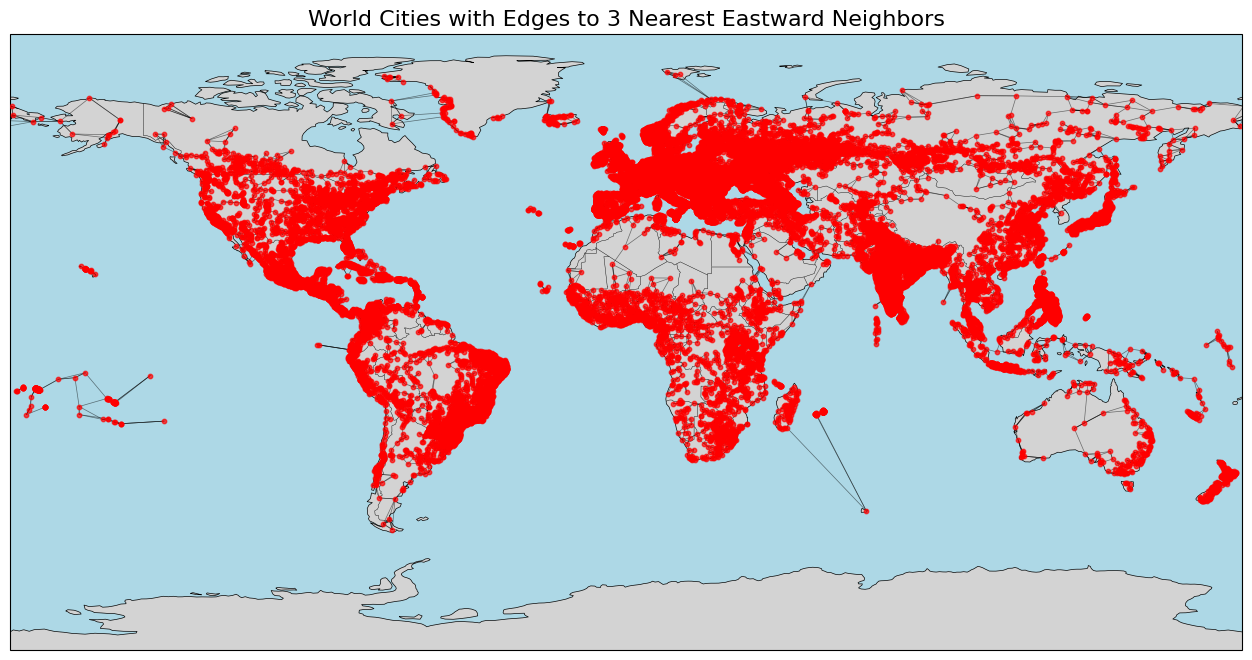

In [5]:
draw_graph_on_world_map(G, df)

We can clearly see that if we follow the rules defined in the task, the continents are separated by the Atlantic Ocean. So, in this case, no way to travel from London around the world back to London exists.

We clearly need to tweak the rules a little.

## 2. Edges between a city and its 3 nearest neighboring EASTWARD cities.

Being able to travel to only the 3 nearest cities does not make much sense, since thinking about it logically, there are many cities in the world for which all the 3 nearest cities are to the west, resulting in dead ends like the one we see above. 

To counter that, we tweak the logic a bit and consider the 3 nearest cities to the EAST.

In [6]:
DATA_PROC = Path("../data/processed/worldcities_processed.csv")
df = pd.read_csv(DATA_PROC)

In [7]:
distances, indices = find_nearest(df, k=500)

In [8]:
G = build_eastward_graph(df, distances, indices)

Spoiler: this did not work either, since there was no path to London that didn't involve travelling a bit to the west. See below.

### Drawing the graph on a world map for inspection

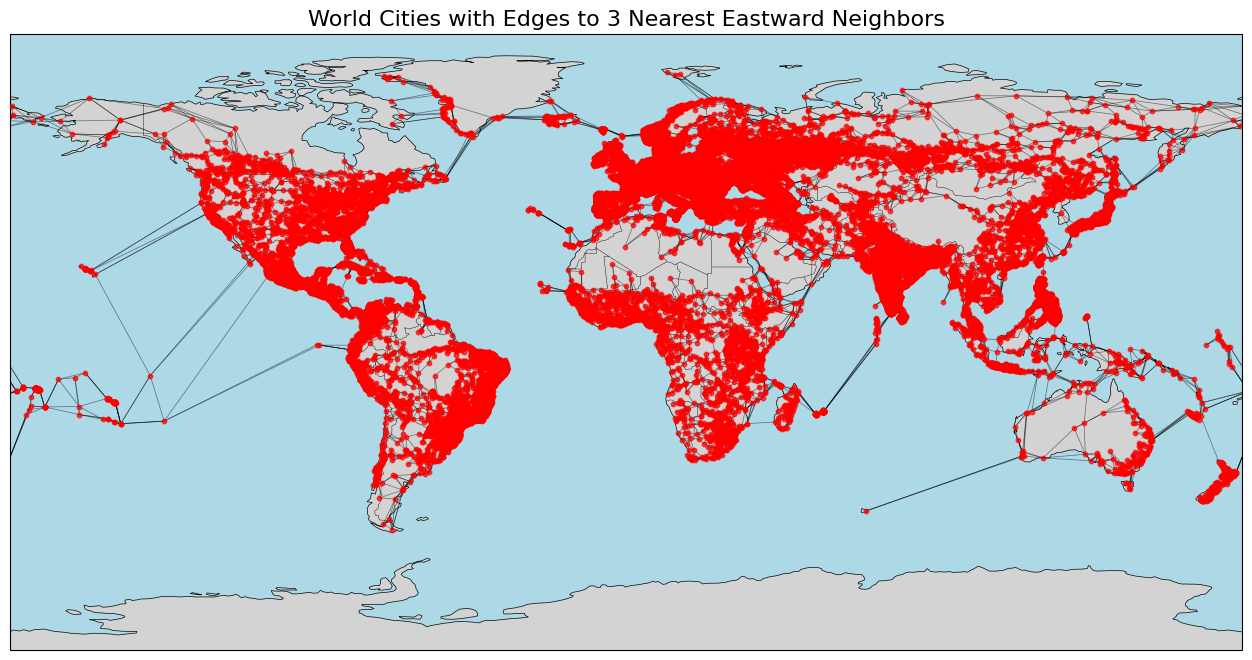

In [9]:
draw_graph_on_world_map(G, df)

Now it is better, but still not enough. We can clearly see that the only connections between islands in the ocean and the continent of Eurasia are the edges that lead to Norway. 

However, there is no way to get from Norway to London by only travelling Eastward.

Unfortunately, we need to change the logic some more.

Note: The lack of the edges from the islands near the UK to the UK seems suspicious, but that's only due to the distortions in projecting a globe onto a 2d picture. The code works correctly, as can be seen if you look at a different projection, for example at this picture: 

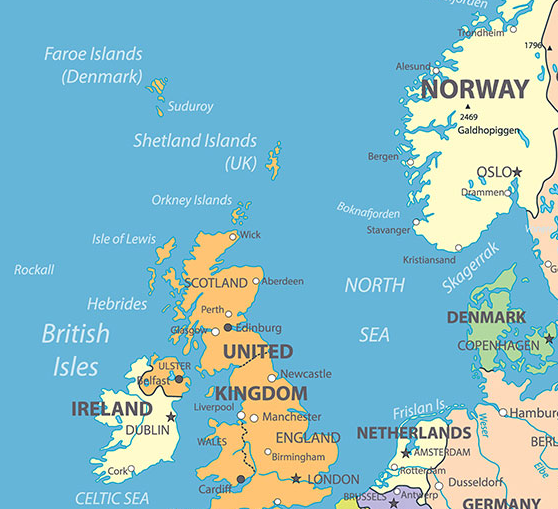

It can be seen that the Faroe Islands are in fact closer to the Shetland Islands than to the UK, and the Shetland Islands cannot be connected to the UK due to the "only east" restriction

## 3. Adding an Extra Edge

So far, we have determined that it is, unfortunately, impossible to find a path if you follow the rules defined in the task

However, I still wanted to know the shortest path from London around the world back into itself, so it was decided to tweak the rules a little bit

The new rule that was added:
- You can travel to the 4th closest city, but the travel time there is 50 hours (to pemnalize skipping cities in path finding algorithm)

In [10]:
DATA_PROC = Path("../data/processed/worldcities_processed_major.csv")
df = pd.read_csv(DATA_PROC)

In [11]:
distances, indices = find_nearest(df, k=500)

In [12]:
G = build_eastward_graph_with_four_neighbors(df, distances, indices)

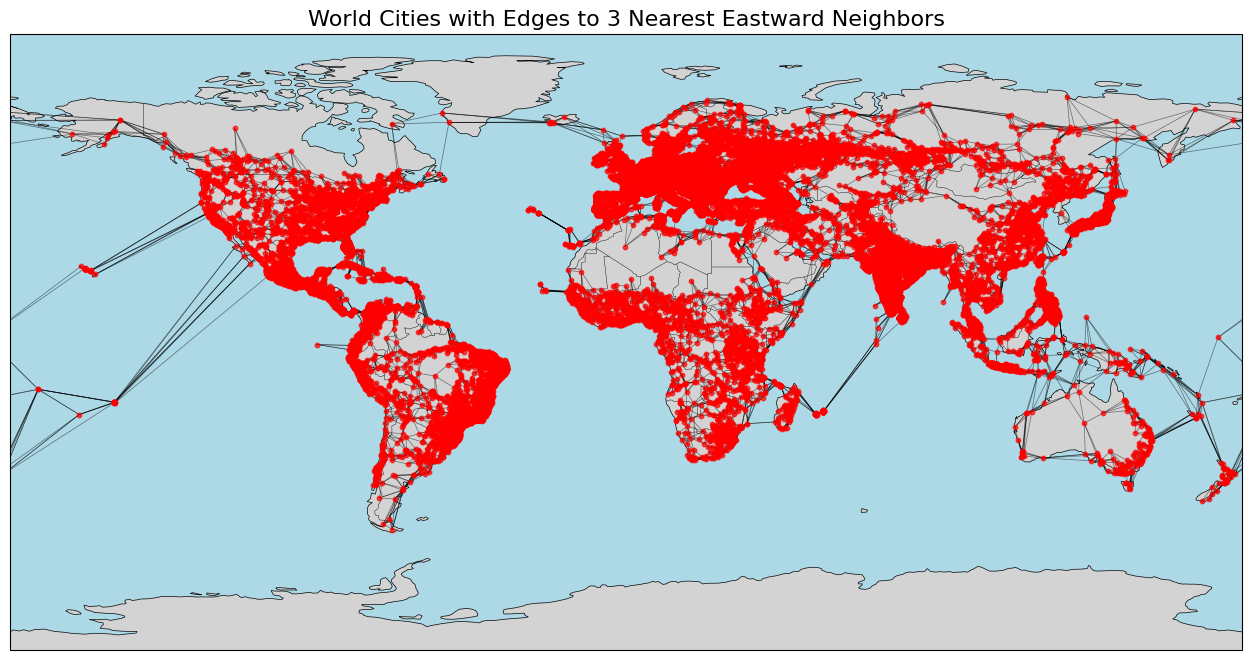

In [13]:
draw_graph_on_world_map(G, df)

Great! Now it's at least interconnected enough for us to actually attempt to find a path!

# Saving the final graph.

In [14]:
GRAPH_PATH = Path("../artifacts/cities_graph_major.pkl")
GRAPH_PATH.parent.mkdir(exist_ok=True)
with open(GRAPH_PATH, "wb") as f:
    pickle.dump(G, f)

print("Graph saved:", GRAPH_PATH)

Graph saved: ..\artifacts\cities_graph_major.pkl
